In [27]:
from utils import database

import numpy as np
import pandas as pd

import folium as fl
from folium import plugins
import geopandas as gpd

import branca
import branca.colormap as cm

import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use("classic")

In [28]:
properties = database.get_properties()

df = pd.DataFrame(
    properties, 
    columns=['price', 'latitude', 'longitude']
)

df['payment_interval'] = df['price'].str.split(" ").str.get(-1)
df['price'] = df['price'].str.split("£").str.get(1).str.split(" ").str.get(0).str.replace(",","").astype(np.float32)
df[['latitude','longitude']] = df[['latitude', 'longitude']].astype(np.float)

def convert_price(x):
    
    if x['payment_interval'] == 'pw':
        return x['price'] * 4
    else:
        return x['price']

df['monthly_price'] = df.apply(convert_price, axis=1)

df.head()

price  latitude  longitude payment_interval  monthly_price
0   500.0  51.52357   -0.05486               pw         2000.0
1   850.0  51.53753   -0.12856               pw         3400.0
2  4312.0  51.52167   -0.08044              pcm         4312.0
3  1100.0  51.44914   -0.05129              pcm         1100.0
4  2000.0  51.44923   -0.01948              pcm         2000.0

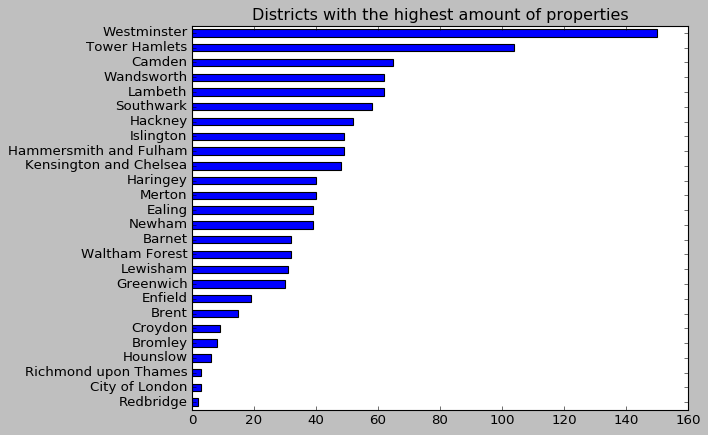

In [29]:
london_districts = gpd.read_file("london.geojson")
london_districts['centroid_x'] = london_districts.geometry.centroid.x
london_districts['centroid_y'] = london_districts.geometry.centroid.y

properties_geo = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs=london_districts.crs)

df = gpd.sjoin(london_districts, properties_geo)

df['name'].value_counts().sort_values().plot(kind='barh')

plt.title("Districts with the highest amount of properties")
plt.show()

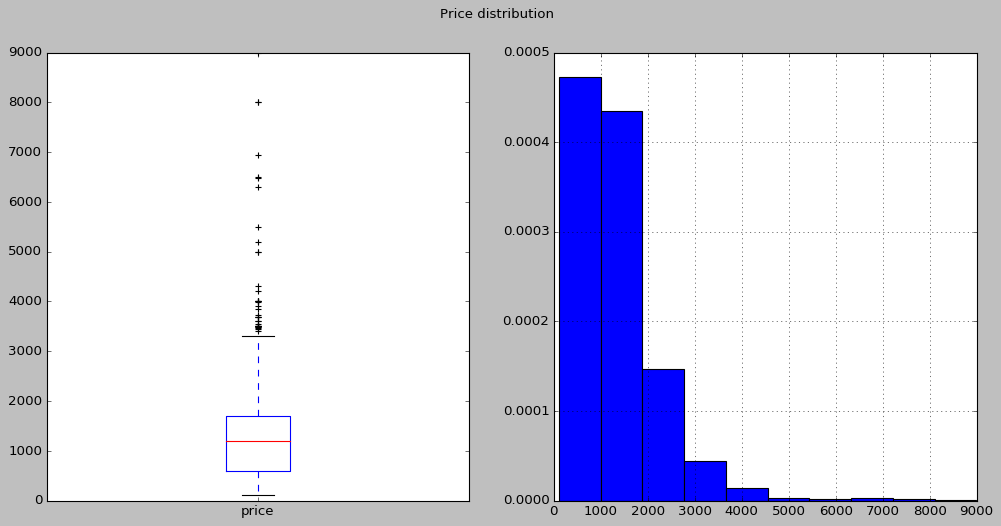

In [30]:
fig, axis = plt.subplots(1,2, figsize=(15,7))


df['price'].plot(kind='box', ax=axis[0], title="")
df['price'].hist(ax=axis[1], density=1)

fig.suptitle("Price distribution")
plt.show()

In [51]:
district_average_price = df.groupby('name', as_index=False)['price'].mean()

# Add the district coordinates
avg_price_df = london_districts.merge(district_average_price, on="name")

m = fl.Map(
    location=[51.518055, -0.181273],
    zoom_start=10,
    zoom_control=False
)

fl.Choropleth(
    geo_data = avg_price_df,
    name="geometry",
    data=avg_price_df,
    columns=['name', 'price'],
    fill_color="YlOrRd",
    key_on="feature.properties.name",
    legend_name = 'Properties monthly rent price'
).add_to(m)

[
    fl.Marker(
        location=[row['centroid_y'], row['centroid_x']],
        popup=row['name'] 
    ).add_to(m)
    
    for ix, row in london_districts.iterrows()
]

display(m)

/home/marco/.local/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
